In [10]:
# %pip install pandas
# %pip install fastparquet # added
# %pip install plotly # added 
# %pip install seaborn matplotlib # added
# %pip install scikit-learn
# %pip install pyarrow # added

  Using cached pyarrow-19.0.0-cp311-cp311-macosx_12_0_x86_64.whl.metadata (3.3 kB)
Using cached pyarrow-19.0.0-cp311-cp311-macosx_12_0_x86_64.whl (32.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

# for visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier if it's a classification task
from sklearn.metrics import mean_squared_error, accuracy_score  # Adjust based on your task
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


import pickle



# Load Data & Initial Exploration
Get a feel for the data, see columns, data types, check for missing values, etc.
NOTE: Depending on data size, Spark/Pyspark can and should be implemented for handling very large datasets. For this exercise, I will work in pandas.

In [11]:
# Load data
building_df = pd.read_parquet('./../data/building_characteristics.parquet', engine='fastparquet')
temperature_df = pd.read_parquet('./../data/temperature.parquet', engine='pyarrow')
consumption_df = pd.read_parquet('./../data/electricity_consumption.parquet', engine='pyarrow')


In [ ]:
# parquet is binary columnar storage v. csv text row storage (less disk space)
# better for storage, enfcoricing schemas, large data processing, etc.

## Building data

In [12]:
building_df.head()

,bldg_id,County,ASHRAE IECC Climate Zone 2004,Occupants,Vintage,Bedrooms,Floor Area SqFt,Geometry Stories,Geometry Garage,Windows,Window Areas,Infiltration,Lighting,Insulation Foundation Wall,Insulation Wall,Insulation Ceiling,Insulation Roof,Insulation Floor,Insulation Rim Joist,HVAC Heating Fuel,HVAC Heating Efficiency,HVAC Cooling Efficiency,Usage Level,Roof Material,Cooling Setpoint,Heating Setpoint,Dishwasher,Cooking Range,Plug Loads,Clothes Dryer,Clothes Washer,Refrigerator,Water Heater Efficiency,Hot Water Fixtures
0,119217,G0600590,3B,3,1970s,4,5587,1,None,"Double, Clear, Non-metal, Air",F18 B18 L18 R18,5 ACH50,100% LED,None,"Wood Stud, Uninsulated",R-13,"Unfinished, Uninsulated",Uninsulated,None,Natural Gas,"Fuel Furnace, 92.5% AFUE","AC, SEER 15",Medium,Composition Shingles,70F,75F,290 Rated kWh,Gas,94%,Gas,Standard,EF 21.9,Natural Gas Standard,100% Usage
1,150215,G0600590,3B,7,1990s,4,2678,1,2 Car,"Double, Low-E, Non-metal, Air, M-Gain",F15 B15 L15 R15,7 ACH50,100% CFL,None,"Wood Stud, R-11",None,"Finished, R-30",None,None,Natural Gas,"Fuel Furnace, 92.5% AFUE","AC, SEER 10",High,Wood Shingles,78F,75F,318 Rated kWh,Electric Resistance,94%,Gas,Standard,EF 15.9,Natural Gas Tankless,200% Usage
2,241378,G0600590,3B,3,1960s,4,2179,2,None,"Single, Clear, Non-metal",F9 B9 L9 R9,30 ACH50,100% LED,None,"Wood Stud, Uninsulated",R-30,"Unfinished, Uninsulated",None,None,Natural Gas,"Fuel Wall/Floor Furnace, 60% AFUE","AC, SEER 13",Medium,"Metal, Dark",76F,72F,318 Rated kWh,Gas,94%,None,Standard,EF 17.6,Natural Gas Standard,100% Usage
3,521946,G0600590,3B,3,1950s,5,5587,2,None,"Double, Low-E, Non-metal, Air, M-Gain",F12 B12 L12 R12,3 ACH50,100% LED,Uninsulated,"Brick, 12-in, 3-wythe, Uninsulated",R-13,"Unfinished, Uninsulated",Uninsulated,Uninsulated,Natural Gas,"Fuel Furnace, 80% AFUE",None,Low,"Asphalt Shingles, Medium",75F,67F,290 Rated kWh,Electric Resistance,94%,Gas,EnergyStar,EF 17.6,Natural Gas Standard,50% Usage
4,508468,G0600590,3B,4,1980s,4,1698,1,None,"Single, Clear, Non-metal",F18 B18 L18 R18,7 ACH50,100% LED,None,"Wood Stud, R-11",Uninsulated,"Unfinished, Uninsulated",None,None,Natural Gas,"Fuel Furnace, 80% AFUE","AC, SEER 13",Medium,"Asphalt Shingles, Medium",68F,70F,318 Rated kWh,Electric Resistance,94%,Gas,EnergyStar,EF 19.9,Natural Gas Premium,100% Usage


In [13]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3978 entries, 0 to 3977
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   bldg_id                        3978 non-null   int64 
 1   County                         3978 non-null   object
 2   ASHRAE IECC Climate Zone 2004  3978 non-null   object
 3   Occupants                      3978 non-null   object
 4   Vintage                        3978 non-null   object
 5   Bedrooms                       3978 non-null   object
 6   Floor Area SqFt                3978 non-null   int64 
 7   Geometry Stories               3978 non-null   object
 8   Geometry Garage                3978 non-null   object
 9   Windows                        3978 non-null   object
 10  Window Areas                   3978 non-null   object
 11  Infiltration                   3978 non-null   object
 12  Lighting                       3978 non-null   object
 13  Ins

## Temperature Data

In [14]:
temperature_df.head()

,county,daily_temperature
0,G0600270,"[2.404166666666667, 3.4416666666666664, 5.4875..."
1,G0600210,"[6.766666666666666, 5.629166666666666, 6.90416..."
2,G0600470,"[3.6999999999999997, 5.795833333333333, 6.3999..."
3,G0600550,"[6.095833333333334, 7.616666666666667, 6.29583..."
4,G0600850,"[8.416666666666666, 8.25, 9.408333333333333, 7..."


In [15]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   county             58 non-null     string
 1   daily_temperature  58 non-null     object
dtypes: object(1), string(1)
memory usage: 1.0+ KB


In [16]:
# do a quick check to ensure that each county contains temp data for all days; the workflow should be made more robust in reality if this were not the case (and should be anyways, in case data is missing in some instances)
temperature_df['num_days'] = temperature_df['daily_temperature'].apply(lambda row: len(row))
temperature_df[temperature_df['num_days']!=365]

,county,daily_temperature,num_days


## Consumption Data

In [17]:
consumption_df.head()

,bldg_id,date,electricity_consumption_kwh
0,133,2018-01-01,1.497375
1,133,2018-01-02,1.468083
2,133,2018-01-03,1.589125
3,133,2018-01-04,1.491625
4,133,2018-01-05,1.516208


In [18]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451970 entries, 0 to 1451969
Data columns (total 3 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   bldg_id                      1451970 non-null  Int64         
 1   date                         1451970 non-null  datetime64[ns]
 2   electricity_consumption_kwh  1451970 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(1)
memory usage: 34.6 MB


## Intial Thoughts:
* Can tie consumption to building data on building id (bldg_id)
* Can tie temp data to building data on county id (county/County)
* Most of the building data is contained as string type objects - will likely want/need to re-cast at least some of these
* Temperature data is not in a "nice" format. The temp values are contianed in a single array of length 365 (for each day of the year) for each county. This will need some manipulation to transform the data into a usable format. 
    * Ideally, if we know the data source for temperature data is always in this format - this should be done in a re-usable format as part of the ETL process.
* Since the end point needs to take in *monthly* temperature and output *monthly* consumption, these daily values should be aggregated to monthly before feeding into the model or performing EDA (ideally, a model would be able to include daily temperature fluctuations, but this set up envforces this monthly constraint)
    * Temperature needs to be *averaged*, while consumption data needs to be *summed* - the average monthly temperature will impact the total monthly consumption

## Aggregate Daily Values & Merge with Building Data

### Aggregate Temperature data
NOTE: In reality, may want to provide additional data quality checks to ensure completeness of data, no outliers in data, etc. to ensure monthly average estimates are valid based on the input data. These could be added as methods in the class below (or kept outside as functions, if they are flexible enough to be used with other timeseries datasets).


In [19]:

class TemperatureDataProcessor:
    def __init__(self, leap_year=False):
        self.days_in_month = self.get_days_in_month(leap_year)

    def get_days_in_month(self, leap_year: bool) -> list:
        """Returns an array containing the number of days in each month, dependent on whether or not
        it is designated as a leap year. If it is a leap year, February gets an extra day.

        NOTE: This method assumes that there are 365 (or 366) daily readings for temperature!

        Args:
            leap_year (bool): True/False indicator for leap year

        Returns:
            list: A list of len 12 containing the days of each month of the year.
        """
        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        if leap_year:
            days_in_month[1] += 1
        return days_in_month
    

    def calculate_monthly_temp_averages(self, daily_temps) -> list:
        """Calculates the monthly average temperatures from daily temperatures.

        Args:
            daily_temps (list): A list of daily temperatures for the entire year.

        Returns:
            list: A list of monthly average temperatures.
        """
        monthly_avg_temps = []
        start_idx = 0
        for days in self.days_in_month:
            end_idx = start_idx + days
            monthly_avg = np.mean(daily_temps[start_idx:end_idx])
            monthly_avg_temps.append(monthly_avg)
            start_idx = end_idx
        return monthly_avg_temps

    def get_monthly_temp_df(self, daily_temp_df: pd.DataFrame) -> pd.DataFrame:
        """Processes the daily temperature DataFrame to calculate and return monthly averages.

        Args:
            daily_temp_df (pd.DataFrame): DataFrame with daily temperature data.

        Returns:
            pd.DataFrame: DataFrame with monthly average temperatures.
        """
        # Get monthly average temperature values
        daily_temp_df['monthly_avg_temp'] = daily_temp_df['daily_temperature'].apply(
            self.calculate_monthly_temp_averages
        )

        # Create a row for each month:
        daily_temp_df = daily_temp_df.explode('monthly_avg_temp').reset_index(drop=True)

        # Add month column
        daily_temp_df['month'] = pd.period_range(start='2018-01', periods=12, freq='M').tolist() * (len(daily_temp_df) // 12)

        # Filter to only relevant columns
        monthly_temperature_df = daily_temp_df[['county', 'monthly_avg_temp', 'month']]

        # Rename county column to be ready for joining with building data
        monthly_temperature_df = monthly_temperature_df.rename(columns={'county': 'County'})

        return monthly_temperature_df


In [20]:
temperature_processor = TemperatureDataProcessor(leap_year=False)


In [21]:
monthly_average_temperatures = temperature_processor.get_monthly_temp_df(temperature_df)


In [22]:
monthly_average_temperatures

,County,monthly_avg_temp,month
0,G0600270,4.126747,2018-01
1,G0600270,5.699702,2018-02
2,G0600270,8.006183,2018-03
3,G0600270,14.221806,2018-04
4,G0600270,18.879704,2018-05
...,...,...,...
691,G0600770,23.725806,2018-08
692,G0600770,21.830278,2018-09
693,G0600770,16.451613,2018-10
694,G0600770,11.406944,2018-11


### Aggregate Consumption Data
NOTE: The same checks that should be applied to the daily temperature data (completeness, outliers, etc.) can and should be performed here.

In [23]:
def get_monthly_consumption_df(daily_consumption_data: pd.DataFrame) -> pd.DataFrame:
    """Sums the daily electricity consumption (kWh) into a monthly aggregrate and creates
    a 'month' date period column for future join in ETL process.

    Args:
        daily_consumption_data (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    # create monthly period column
    daily_consumption_data['month'] = daily_consumption_data['date'].dt.to_period('M')

    # aggregate to monthly usage 
    monthly_consumption_df = consumption_df.groupby(['bldg_id', 'month']).agg({'electricity_consumption_kwh': 'sum'}).reset_index()

    return monthly_consumption_df



In [24]:
monthly_consumption_df = get_monthly_consumption_df(daily_consumption_data=consumption_df)


In [25]:
monthly_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47736 entries, 0 to 47735
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype    
---  ------                       --------------  -----    
 0   bldg_id                      47736 non-null  Int64    
 1   month                        47736 non-null  period[M]
 2   electricity_consumption_kwh  47736 non-null  float64  
dtypes: Int64(1), float64(1), period[M](1)
memory usage: 1.1 MB


### Merge with Building Data for Complete Model Dataset (starting point)

In [26]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3978 entries, 0 to 3977
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   bldg_id                        3978 non-null   int64 
 1   County                         3978 non-null   object
 2   ASHRAE IECC Climate Zone 2004  3978 non-null   object
 3   Occupants                      3978 non-null   object
 4   Vintage                        3978 non-null   object
 5   Bedrooms                       3978 non-null   object
 6   Floor Area SqFt                3978 non-null   int64 
 7   Geometry Stories               3978 non-null   object
 8   Geometry Garage                3978 non-null   object
 9   Windows                        3978 non-null   object
 10  Window Areas                   3978 non-null   object
 11  Infiltration                   3978 non-null   object
 12  Lighting                       3978 non-null   object
 13  Ins

In [27]:
eda_data = building_df.merge(monthly_average_temperatures, on='County')

In [28]:
eda_data = eda_data.merge(monthly_consumption_df, on=['bldg_id', 'month'])

In [29]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47736 entries, 0 to 47735
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype    
---  ------                         --------------  -----    
 0   bldg_id                        47736 non-null  int64    
 1   County                         47736 non-null  object   
 2   ASHRAE IECC Climate Zone 2004  47736 non-null  object   
 3   Occupants                      47736 non-null  object   
 4   Vintage                        47736 non-null  object   
 5   Bedrooms                       47736 non-null  object   
 6   Floor Area SqFt                47736 non-null  int64    
 7   Geometry Stories               47736 non-null  object   
 8   Geometry Garage                47736 non-null  object   
 9   Windows                        47736 non-null  object   
 10  Window Areas                   47736 non-null  object   
 11  Infiltration                   47736 non-null  object   
 12  Lighting          

In [30]:
eda_data.head()

,bldg_id,County,ASHRAE IECC Climate Zone 2004,Occupants,Vintage,Bedrooms,Floor Area SqFt,Geometry Stories,Geometry Garage,Windows,Window Areas,Infiltration,Lighting,Insulation Foundation Wall,Insulation Wall,Insulation Ceiling,Insulation Roof,Insulation Floor,Insulation Rim Joist,HVAC Heating Fuel,HVAC Heating Efficiency,HVAC Cooling Efficiency,Usage Level,Roof Material,Cooling Setpoint,Heating Setpoint,Dishwasher,Cooking Range,Plug Loads,Clothes Dryer,Clothes Washer,Refrigerator,Water Heater Efficiency,Hot Water Fixtures,monthly_avg_temp,month,electricity_consumption_kwh
0,119217,G0600590,3B,3,1970s,4,5587,1,None,"Double, Clear, Non-metal, Air",F18 B18 L18 R18,5 ACH50,100% LED,None,"Wood Stud, Uninsulated",R-13,"Unfinished, Uninsulated",Uninsulated,None,Natural Gas,"Fuel Furnace, 92.5% AFUE","AC, SEER 15",Medium,Composition Shingles,70F,75F,290 Rated kWh,Gas,94%,Gas,Standard,EF 21.9,Natural Gas Standard,100% Usage,13.282392,2018-01,27.752417
1,119217,G0600590,3B,3,1970s,4,5587,1,None,"Double, Clear, Non-metal, Air",F18 B18 L18 R18,5 ACH50,100% LED,None,"Wood Stud, Uninsulated",R-13,"Unfinished, Uninsulated",Uninsulated,None,Natural Gas,"Fuel Furnace, 92.5% AFUE","AC, SEER 15",Medium,Composition Shingles,70F,75F,290 Rated kWh,Gas,94%,Gas,Standard,EF 21.9,Natural Gas Standard,100% Usage,13.986607,2018-02,25.512292
2,119217,G0600590,3B,3,1970s,4,5587,1,None,"Double, Clear, Non-metal, Air",F18 B18 L18 R18,5 ACH50,100% LED,None,"Wood Stud, Uninsulated",R-13,"Unfinished, Uninsulated",Uninsulated,None,Natural Gas,"Fuel Furnace, 92.5% AFUE","AC, SEER 15",Medium,Composition Shingles,70F,75F,290 Rated kWh,Gas,94%,Gas,Standard,EF 21.9,Natural Gas Standard,100% Usage,16.203091,2018-03,36.527708
3,119217,G0600590,3B,3,1970s,4,5587,1,None,"Double, Clear, Non-metal, Air",F18 B18 L18 R18,5 ACH50,100% LED,None,"Wood Stud, Uninsulated",R-13,"Unfinished, Uninsulated",Uninsulated,None,Natural Gas,"Fuel Furnace, 92.5% AFUE","AC, SEER 15",Medium,Composition Shingles,70F,75F,290 Rated kWh,Gas,94%,Gas,Standard,EF 21.9,Natural Gas Standard,100% Usage,15.995,2018-04,33.115583
4,119217,G0600590,3B,3,1970s,4,5587,1,None,"Double, Clear, Non-metal, Air",F18 B18 L18 R18,5 ACH50,100% LED,None,"Wood Stud, Uninsulated",R-13,"Unfinished, Uninsulated",Uninsulated,None,Natural Gas,"Fuel Furnace, 92.5% AFUE","AC, SEER 15",Medium,Composition Shingles,70F,75F,290 Rated kWh,Gas,94%,Gas,Standard,EF 21.9,Natural Gas Standard,100% Usage,18.001747,2018-05,38.518542


### Extract Numeric Data From Building Data and Re-Cast as Necessary

#### Reformat String Columns Containing Numeric Data
I took a quick look into the columns which contained numeric data, identified ones that I felt may be relevant to a model, and modified them so I could convert the datatype to a numeric format. With more time, additional anayalis and feature engineering might be implemented to extract more numeric columns.

In [31]:
eda_data['Occupants'] = eda_data['Occupants'].str.replace('+', '')

eda_data['Vintage'] = eda_data['Vintage'].str.replace('s', '')
eda_data['Vintage'] = eda_data['Vintage'].str.replace('<', '')

eda_data['Cooling Setpoint'] = eda_data['Cooling Setpoint'].str.replace('F', '')
eda_data['Heating Setpoint'] = eda_data['Heating Setpoint'].str.replace('F', '')

In [32]:
to_numeric_cols = [
    'Occupants',
    'Vintage',
    'Floor Area SqFt',
    'Bedrooms',
    'Geometry Stories',
    'Cooling Setpoint',
    'Heating Setpoint',  
]

In [33]:
for col in to_numeric_cols:
    eda_data[col] = eda_data[col].astype('int')

eda_data['monthly_avg_temp'] = eda_data['monthly_avg_temp'].astype('float')

In [34]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47736 entries, 0 to 47735
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype    
---  ------                         --------------  -----    
 0   bldg_id                        47736 non-null  int64    
 1   County                         47736 non-null  object   
 2   ASHRAE IECC Climate Zone 2004  47736 non-null  object   
 3   Occupants                      47736 non-null  int64    
 4   Vintage                        47736 non-null  int64    
 5   Bedrooms                       47736 non-null  int64    
 6   Floor Area SqFt                47736 non-null  int64    
 7   Geometry Stories               47736 non-null  int64    
 8   Geometry Garage                47736 non-null  object   
 9   Windows                        47736 non-null  object   
 10  Window Areas                   47736 non-null  object   
 11  Infiltration                   47736 non-null  object   
 12  Lighting          

# EDA - Explore Potential Features

In [35]:
potential_numeric_features = [
    'Occupants',
    'Vintage',
    'Floor Area SqFt',
    'Bedrooms',
    'Geometry Stories',
    'Cooling Setpoint',
    'Heating Setpoint', 
    'monthly_avg_temp' 
]

Create plots to evaluate relationship between hand selected numeric features and target variable (electricity consumption).

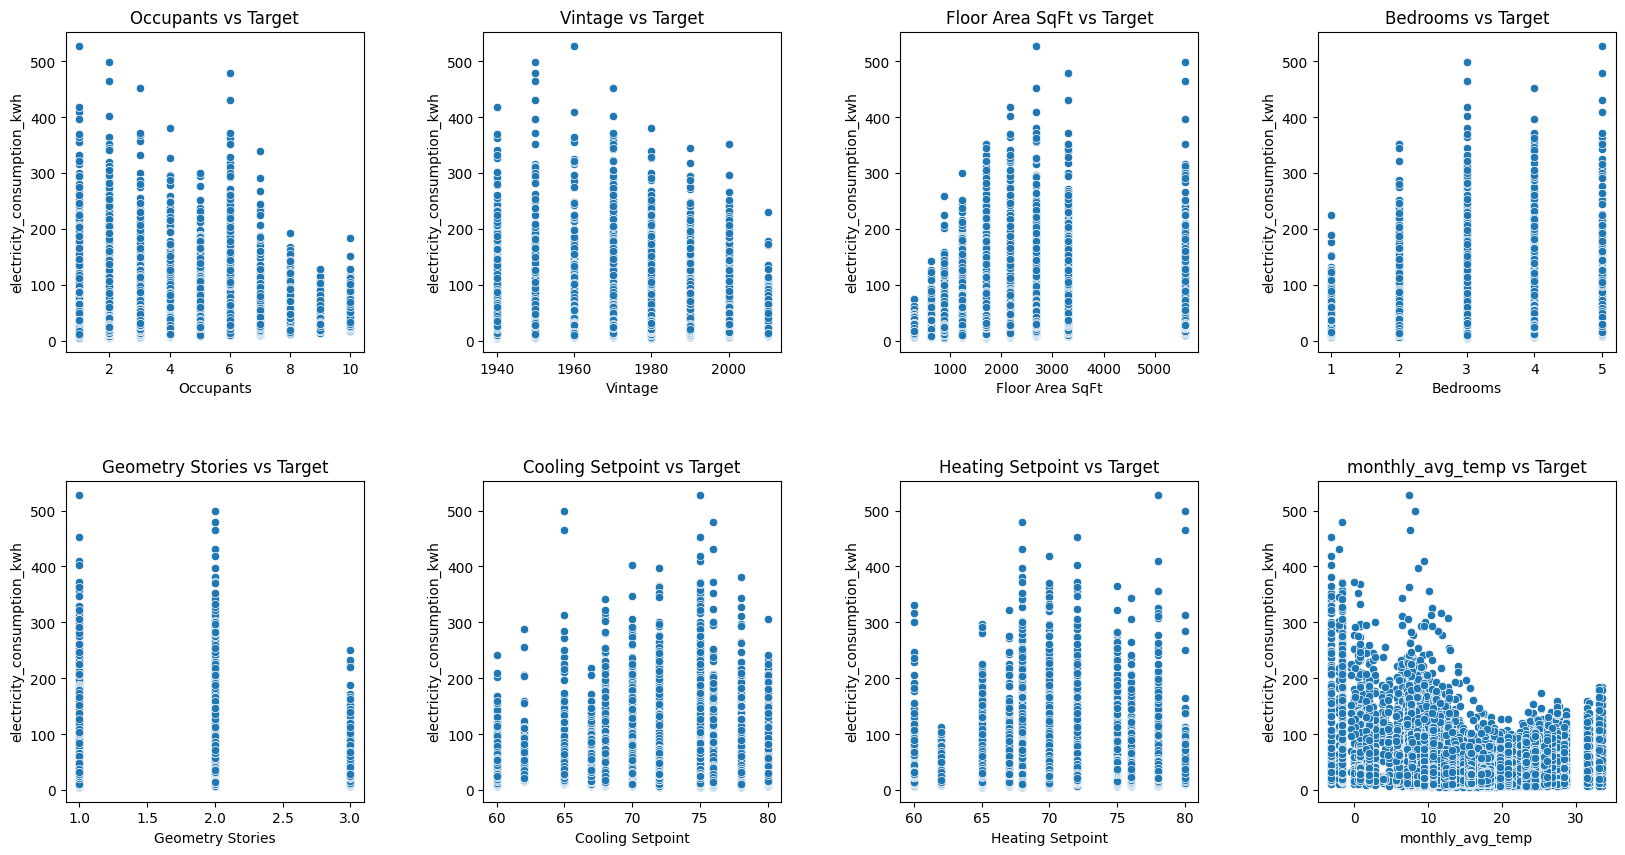

In [36]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot each feature against the target
for i, feature in enumerate(potential_numeric_features):
    sns.scatterplot(x=feature, y='electricity_consumption_kwh', data=eda_data, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'{feature} vs Target')

plt.show()

## Numeric Feature Engineering

In [37]:
# create additional features

# temperature appears to exhibit a slight polynomial relationship, with consumption increasing with both very high and very low temps (which makes sense, intuitively)
eda_data['avg_temperature_squared'] = eda_data['monthly_avg_temp'] ** 2

# I'm interested in creating a feature to calculate how far away the temp is from heating or cooling set point
def calculate_temp_deviation(row):
    if row['monthly_avg_temp'] > row['Cooling Setpoint']:
        # Temperature is above the cooling set point
        return row['monthly_avg_temp'] - row['Cooling Setpoint']
    elif row['monthly_avg_temp'] < row['Heating Setpoint']:
        # Temperature is below the heating set point
        return row['Heating Setpoint'] - row['monthly_avg_temp'] 
    else:
        # Temperature is within the range
        return 0

# Apply the function to create the new variable
eda_data['temp_deviation'] = eda_data.apply(calculate_temp_deviation, axis=1)


In [38]:
potential_numeric_features_updated = [
    'Occupants',
    'Vintage',
    'Floor Area SqFt',
    'Bedrooms',
    'Geometry Stories',
    'Cooling Setpoint',
    'Heating Setpoint', 
    'monthly_avg_temp' ,
    'avg_temperature_squared',
    'temp_deviation'
]

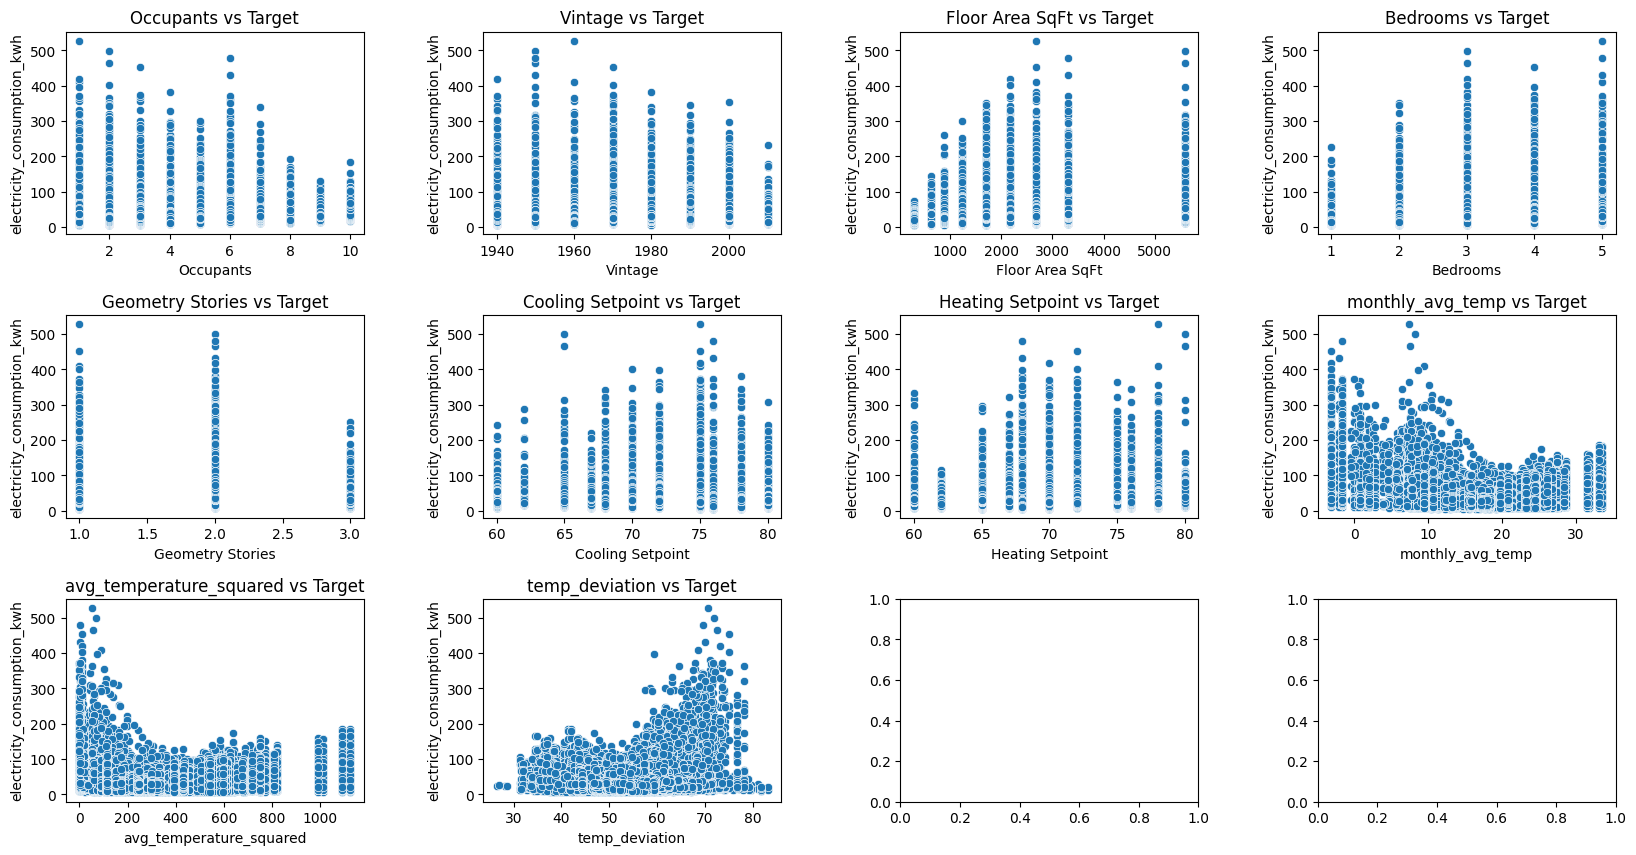

In [39]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot each feature against the target
for i, feature in enumerate(potential_numeric_features_updated):
    sns.scatterplot(x=feature, y='electricity_consumption_kwh', data=eda_data, ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'{feature} vs Target')

plt.show()

## Thoughts
While some of these numeric variables exhibit linearity, not all of them do. I was hoping to implement a linear regression model, because they have the benefit of being easy to interpret (the coefficients represent the change in the target variable for a one-unit change in the feature). This would come in handy for example, if a customer wanted to know the ONE or TWO things they should prioritize to reduce their electricity consumptions (and therefore, electricity bill). That being said, further feature transformations would be required (transforming the skewed data, etc), handling of non-numeric features, and testing if all of the assumptions required for a linear regression to hold would take more time than I have available currently. I will plan to implement a Random Forest model for this excercise as they are generally a good starting point, especially with non-linear or mixed data types (numeric and categorical). You can also glean some information about feature importance with a Random Forest Model. 

In [40]:
# potential transformations to explore
# log - compress large values and spread out small; can help reduce skew
# sqrt - help stsabilize variance and reduce indluence of large values

# Random Forest Model Development

I chose to exclude some of the exlpored numeric features based on assumed correlation. For example, number of occupants is generally a good indicator of the number of bedrooms.

In [41]:
model_numeric_features = [
    "temp_deviation",
    "Vintage",
    "Floor Area SqFt",
    "Occupants"
]

I chose the below list of categorical features based on my background knowledge of what drives energy efficiency in buildings. In reality a more in depth feature exploration should be implemented to understand what features should be used in the model (for both numeric and categorical).

In [42]:
model_categorical_features =  [
    "ASHRAE IECC Climate Zone 2004",
    "Windows",
    "Insulation Wall",
    "Insulation Roof",
    "Insulation Floor",
    "HVAC Heating Fuel",
    "Roof Material",
    "Water Heater Efficiency"
]

NOTE: In reality, more in depth feautre engineering should be implemented (if time allows). There is more to explore here!

In [43]:
target = 'electricity_consumption_kwh'

In [44]:
# split the data into train and test sets
X = eda_data[model_numeric_features + model_categorical_features]
y = eda_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# undestand input types - required for API development
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47736 entries, 0 to 47735
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   temp_deviation                 47736 non-null  float64
 1   Vintage                        47736 non-null  int64  
 2   Floor Area SqFt                47736 non-null  int64  
 3   Occupants                      47736 non-null  int64  
 4   ASHRAE IECC Climate Zone 2004  47736 non-null  object 
 5   Windows                        47736 non-null  object 
 6   Insulation Wall                47736 non-null  object 
 7   Insulation Roof                47736 non-null  object 
 8   Insulation Floor               47736 non-null  object 
 9   HVAC Heating Fuel              47736 non-null  object 
 10  Roof Material                  47736 non-null  object 
 11  Water Heater Efficiency        47736 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usag

NOTE: No scaling is needed necessarily for a Random Forest model, but is IS generally required to gain a better understanding of feature importance. With more time (assuming a Random Forest was solidified as the model of choice), a StandardScalaer should be applied to the input numeric features so that information about feature importance may be gleaned. Again, this goes back to providing clients with insights about *how* they can reduce their electricity consumption.

Feature importance is calculated based on how each feature contributes to reducing the impurity (Gini index or entropy) across all tress in the forest. You can use feature_importances_ attribute to inspect these results after the model run (IF the data is stnadardized).

Could also have included all features, and then iterate using Recursive Feature Elimintation (RFE) with random forest to determine the best subset of features to use (based on feature importance).

In [46]:
# apply OneHotEncoding for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), model_categorical_features)
    ],
    remainder='passthrough'  
)

In [47]:
# create a pipeline that first preprocesses the data, then fits the RF model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42)) 
])

## Hyper-parameter tuning

In [48]:
# Define the parameter grid to search over
param_distributions = {
    'model__n_estimators': [100, 200, 500],  # Number of trees (trade off between accuracy and speed)
    'model__max_depth': [10, 20, 30],  # Maximum depth of trees (shorter tress limit over fitting - variance v. bias trade off)
    'model__min_samples_split': [2, 5, 10],  # Minimum samples to split a node (higher values reduce overfitting by increasing generalization)
    'model__min_samples_leaf': [1, 2, 4],    # Minimum samples at leaf node
    'model__max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'model__bootstrap': [True, False]        # Whether to use bootstrap samples - false trains on the entire dataset, increasing variance
}

In [49]:
# Set up RandomizedSearchCV with neg RMSE scoring
# RandomizedSearchCV uses a higher scoring metric value to indicate a better model (like R2)
# we want to minimize RMSE - so flip the sign here
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,       # Cross-validation splits
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

"""
Going back to review, I realized I evaluated my model on MSE, not RMSE. I like to use RMSE because
it outputs the same units as the target, making it easier to interpret. MSE does penalize large 
errors more, but I like RMSE becuase it is easy to interpret, especially in this case where we 
are predicting kWh.
"""

# from sklearn.metrics import make_scorer, mean_squared_error

# # Define a custom scoring function for RMSE
# def rmse_score(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# # Create a scorer object using the custom RMSE function
# rmse_scorer = make_scorer(rmse_score, greater_is_better=False)


'\nGoing back to review, I realized I evaluated my model on MSE, not RMSE. I like to use RMSE because\nit outputs the same units as the target, making it easier to interpret. MSE does penalize large \nerrors more, but I like RMSE becuase it is easy to interpret, especially in this case where we \nare predicting kWh.\n'

## Model fit

In [53]:
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/alextruby/repos/monthly-electricity-predictions/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['ASHRAE '
                                                                                'IECC '
                                                                                'Climate '
                                                                                'Zone '
                                                                                '2004',
                                                                                'Windows',
                                                                                'Insulation '
                                                                                'Wall',
                                                                                'Insulation '
                                                                                'Roof',
                                                                                'Insulation '
                                                                                'Floor',
                                                                                'HVAC '
                                                                                'Heating '
                                                                                'Fuel',
                                                                                'Roof '
                                                                                'Material',
                                                                                'Water '
                                                                                'Heater '
                                                                                'Efficiency'])])),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [54]:
best_model = random_search.best_estimator_


## Model predictions & eval

In [55]:
y_pred = best_model.predict(X_test)


In [56]:
# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (Best Model): {rmse}')
print(f'Best Parameters: {random_search.best_params_}')

Root Mean Squared Error (Best Model): 8.456593836110745
Best Parameters: {'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 30, 'model__bootstrap': True}


# Visualize distribution of electricity consumption
This helps me to understand how my model is performing at a quick glance.

In [57]:
rmse

np.float64(8.456593836110745)

Average Month-to-Month Difference: 7.00 kWh


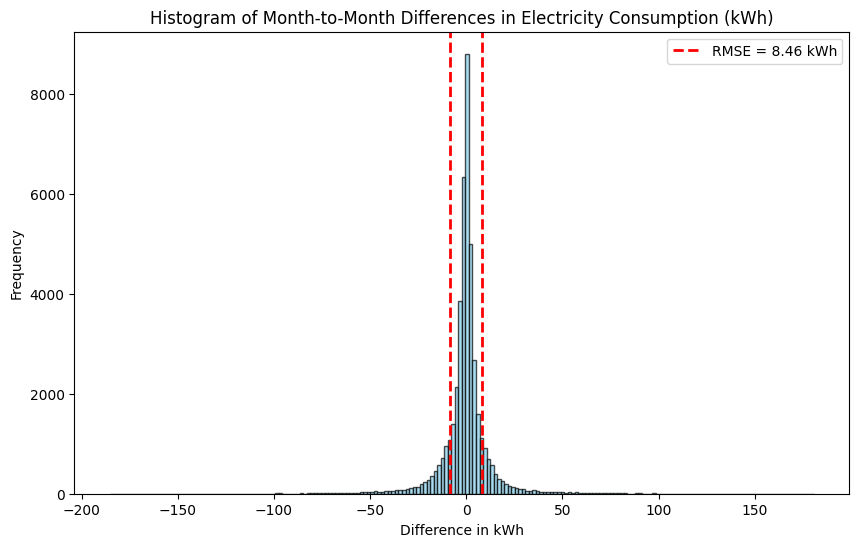

In [58]:
# calculate month-to-month differences for each building
eda_data['month_to_month_diff'] = eda_data.groupby('bldg_id')['electricity_consumption_kwh'].diff()

# drop NaN values (the first difference is NaN since there's no previous month)
kwh_usage_diff_df = eda_data.dropna()

average_month_to_month_diff = kwh_usage_diff_df['month_to_month_diff'].abs().mean()
print(f'Average Month-to-Month Difference: {average_month_to_month_diff:.2f} kWh')

# plot the histogram of month-to-month differences
plt.figure(figsize=(10, 6))
plt.hist(kwh_usage_diff_df['month_to_month_diff'], bins=200, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=rmse, color='red', linestyle='--', linewidth=2, label=f'RMSE = {rmse:.2f} kWh')
plt.axvline(x=-rmse, color='red', linestyle='--', linewidth=2)

plt.title('Histogram of Month-to-Month Differences in Electricity Consumption (kWh)')
plt.xlabel('Difference in kWh')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save Trained Model 

In [59]:
# # Save the trained model to a file
# with open('./../models/electricity_consumption_prototype_model_v2.pkl', 'wb') as model_file:
#     pickle.dump(best_model, model_file)

# Future Improvements
* Build out actual ETL pipelines
* Data quality checks on timeseries (and all) data - continuity, outliers, etc.
* More feature engineering & time on model development
    * Try more/different features
    * Maybe calculate variance or quartiles in monthly temperature, num days outside of setpoints, etc.
    * Depending on goals, work to see if a linear regression model is applicable (test assumptions)
    * Standardization of numeric features in Random Forest (needed to derive feature importance), could also impact model performance
    